## Let's cluster our data

In this notebook, I'll give a brief overview of clustering methods, and show how to inspect clustering performance using umap. This notebook is mostly an application of scikit-learn's clustering tutorial [here].(https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

I will start by showing a manual approach, and then an automated sweep through cluster sizes along with an examination of silhouette scores.

First, we load and format our data, and embed it.

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author, add_text_features_to_df, get_vectorized_series, train_vectorizer

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = add_text_features_to_df(df.loc[df["is_question"]].copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

In [2]:
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])
train_author["vectors"] = train_author["full_text"].apply(lambda x: nlp(x).vector)
vectorized_features= np.vstack(train_author["vectors"])

In [3]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

Now let's cluster the data using [K means](https://en.wikipedia.org/wiki/K-means_clustering). K means requires us to input the desired number of clusters as a parameter. Let's start with three clusters, and visualize our results using UMAP by assigning each cluster a different color.

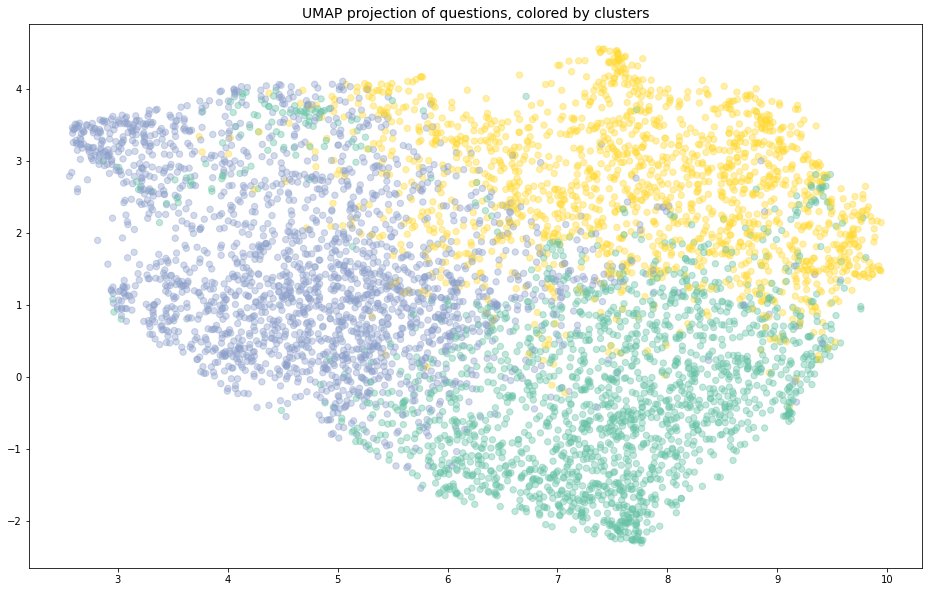

In [4]:
# Choose number of clusters and colormap
n_clusters=3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14);
plt.savefig('../images/bmlpa_figures/ch04-10.png', dpi=300)

#### 번역서 부록

KMeans 알고리즘을 사용할 때 각 샘플을 클러스터의 중심까지의 거리로 표현할 수 있습니다. `KMeans` 클래스의 `trasnform()` 메서드에서 이를 수행합니다. 여기에서 클러스터 개수는 3개 이므로 반환된 데이터의 특성 개수도 3개가 됩니다. 클러스터 중심까지 거리를 사용해 시각화를 하면 종종 더 나은 결과를 보여줍니다.

아래 코드는 `KMeans` 클래스의 `transform()` 메서드로 `vectorized_features`를 `transformed_features`로 변환한 후 UMAP으로 시각화하는 예입니다. 

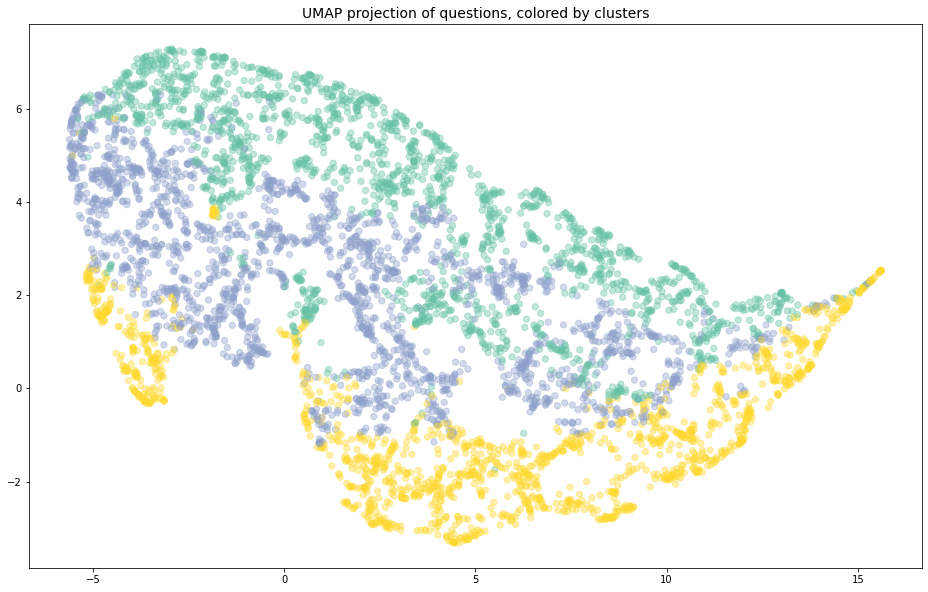

In [5]:
transformed_features = clus.transform(vectorized_features)

umap_features = umap_embedder.fit_transform(transformed_features)

# Plot the dimentionality reduced features on a 2D plane
fig = plt.figure(figsize=(16, 10))
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14);
plt.savefig('../images/bmlpa_figures/ch04-10A.png', dpi=300)

---

Looking at this plot, it is unclear whether we have picked the right number of clusters. Certain region seem to be associated to a unique clusters, while others are split. Let's try out different values for the numbers of clusters, and plot the umap projection, as well as the [silhouette score and samples](https://en.wikipedia.org/wiki/Silhouette_(clustering)) for each.

For n_clusters = 2 The average silhouette_score is : 0.1693822
(2, 300)
For n_clusters = 3 The average silhouette_score is : 0.075936936
(3, 300)
For n_clusters = 4 The average silhouette_score is : 0.0636554
(4, 300)
For n_clusters = 5 The average silhouette_score is : 0.05683346
(5, 300)
For n_clusters = 6 The average silhouette_score is : 0.034223337
(6, 300)


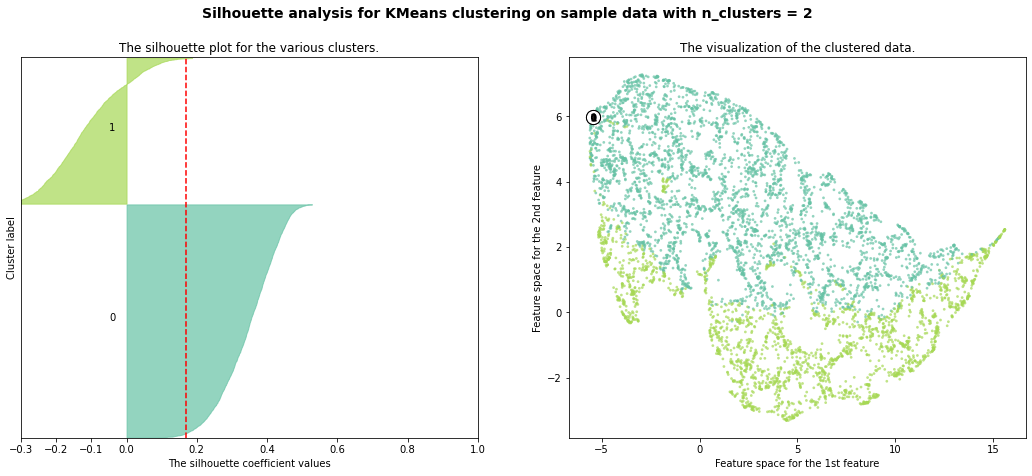

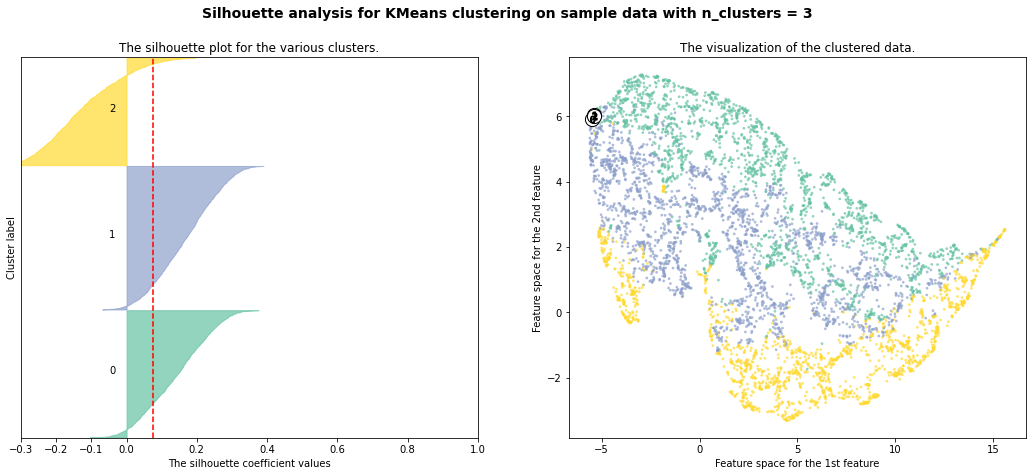

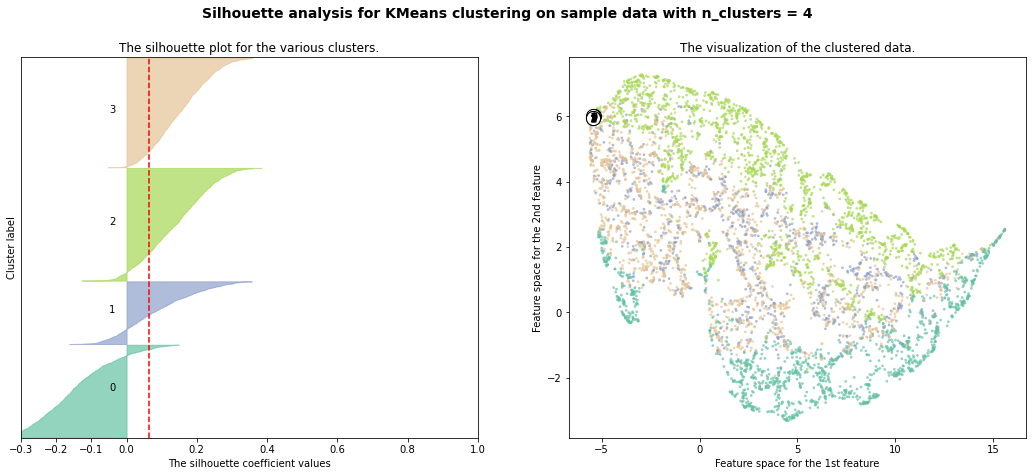

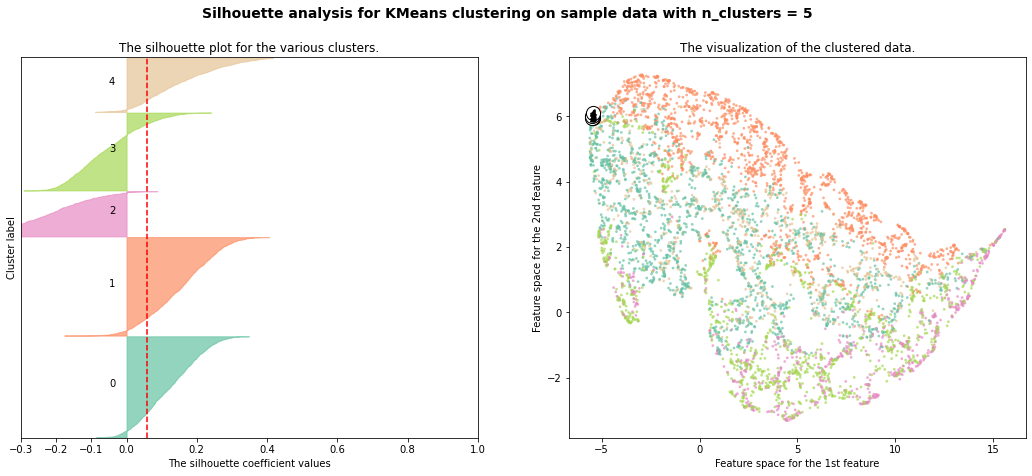

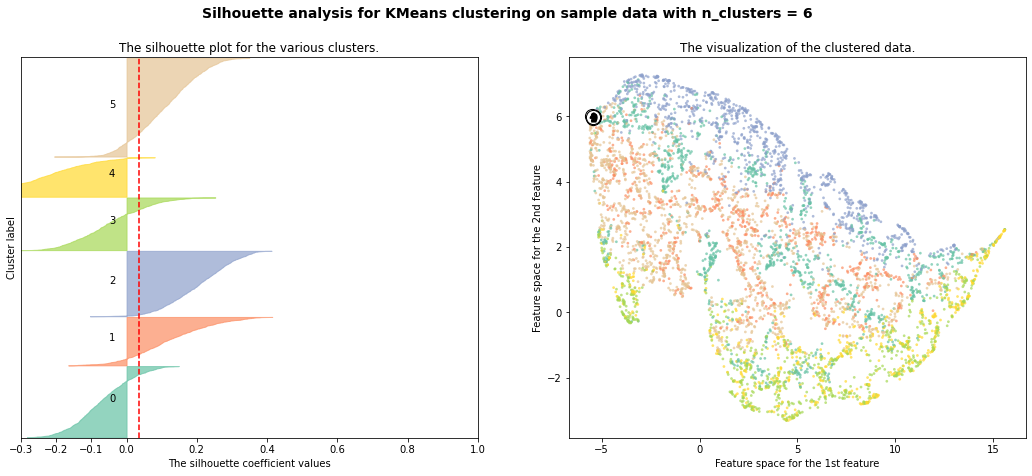

In [6]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = [2, 3, 4, 5, 6]

to_clus = vectorized_features

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-.3, .4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(to_clus) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(to_clus)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

The aggregate silhouette score is often too high level of a metric to judge clustering quality. To show a more nuanced view, silhouette plots display each individual data point's silhouette score broken down by cluster.

In a perfect situation, most points within a cluster would have a silhouette score that is close to 1. In our example, while no number of clusters seems optimal, three and four clusters produce silhouette plots with the largest proportion of points receiving a positive score. For readers that want to explore clustering further, I recommend experimenting with other approaches such as DBSCAN or MeanShift (see [sklearn](https://scikit-learn.org/stable/modules/clustering.html) for examples).